In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
import h5py

tf.keras.backend.set_floatx('float32')

plt.rcParams.update({
    "text.usetex":True,
    "font.family":"serif",
})

In [2]:
colab_flag = False
FTYPE = np.float32
ITYPE = np.int32

array = np.array
float32 = np.float32
int32 = np.int32
float64 = np.float64
int64 = np.int64

strategy = None
# strategy = tf.distribute.MirroredStrategy()

xlabel_kwargs = {"fontsize":15}
ylabel_kwargs = {"fontsize":15}
legend_kwargs = {"fontsize":12}
title_kwargs = {"fontsize":18}

In [3]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [4]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [5]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/Kolmogorov


In [6]:
from tools.ae_v11 import Autoencoder

In [7]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 0
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2023-07-17 11:19:40.608569: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-17 11:19:40.650848: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-17 11:19:40.651056: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-17 11:19:40.652123: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

In [8]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print('')
print(tf.config.list_logical_devices())
print('')
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]

2.8.1


# Kolmogorov Flow System

In [9]:
prng_seed = 42
np.random.seed(prng_seed)

train_split = 0.8
val_split = 0.1
test_split = 0.1

In [10]:
ae_idx = '054'
dir_name_ae = os.getcwd()+'{ds}saved_ae{ds}ae_'.format(ds=dir_sep)+ae_idx

# reading simulation parameters
with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
data_dir_idx = params_dict['data_dir_idx']
normalizeforae_flag = params_dict['normalizeforae_flag']
ae_module = params_dict['module']
try:
    use_ae_data = params_rnn_dict['use_ae_data']
except:
    print("'use_ae_data' not present in RNN_specific_data, set to True.")
    use_ae_data = True
try:
    ae_data_with_params = params_dict['ae_data_with_params']
except:
    print("'ae_data_with_params' not present in ae_data, set to 'True'.")
    ae_data_with_params = True

if os.path.exists(dir_name_ae+dir_sep+'normalization_data.npz'):
    with np.load(dir_name_ae+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
        normalization_constant_arr_aedata = fl['normalization_constant_arr_aedata'][0]
print('data_dir_idx:', data_dir_idx)

# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx

with h5py.File(dir_name_data + '/data.h5', 'r') as f:
    t_recorded_samples = np.array(f['t'])
    
    N = int(0.5*(np.array(f['num_wavenumbers'])-1))
    print(N, type(N))
    N_ref = int(np.array(f['N_ref']))
    
    try:
        u_ref = np.array(f['u_reference'], dtype=FTYPE)
        v_ref = np.array(f['v_reference'], dtype=FTYPE)
    except:
        uh = np.empty(shape=(len(t_recorded_samples), 2*N+1, 2*N+1), dtype=np.complex128)
        uh[:, :, N:] = np.array(f['uh'])
        uh[:, 0:N, 0:N] = np.conjugate(uh[:, N+1:, N+1:][:, ::-1, ::-1])
        uh[:, N+1:, 0:N] = np.conjugate(uh[:, 0:N, N+1:][:, ::-1, ::-1])

        vh = np.empty(shape=(len(t_recorded_samples), 2*N+1, 2*N+1), dtype=np.complex128)
        vh[:, :, N:] = np.array(f['vh'])
        vh[:, 0:N, 0:N] = np.conjugate(vh[:, N+1:, N+1:][:, ::-1, ::-1])
        vh[:, N+1:, 0:N] = np.conjugate(vh[:, 0:N, N+1:][:, ::-1, ::-1])

        u_ref = np.fft.irfft2(np.fft.ifftshift(uh), s=(N_ref, N_ref))
        del(uh)
        v_ref = np.fft.irfft2(np.fft.ifftshift(vh), s=(N_ref, N_ref))
        del(vh)

'use_ae_data' not present in RNN_specific_data, set to True.
data_dir_idx: 002
32 <class 'int'>


In [11]:
all_data_og = np.empty(shape=(u_ref.shape[0], 2, u_ref.shape[1], u_ref.shape[2]), dtype=FTYPE)
all_data_og[:, 0, :, :] = u_ref
del(u_ref)
all_data_og[:, 1, :, :] = v_ref
del(v_ref)

In [12]:
num_params = 1
og_vars = all_data_og.shape[1:]
all_data_og_shape = all_data_og.shape

print('num_params : ', num_params)
print('og_vars : ', og_vars)
print('all_data_og.shape : ', all_data_og_shape)

num_params :  1
og_vars :  (2, 50, 50)
all_data_og.shape :  (120001, 2, 50, 50)


In [13]:
# all_data_og = all_data_og[::3]
all_data_og_shape = all_data_og.shape
print('all_data_og.shape : ', all_data_og_shape)

all_data_og.shape :  (120001, 2, 50, 50)


In [14]:
num_train = int(all_data_og.shape[0]*train_split)
num_val = int(all_data_og.shape[0]*val_split)
num_test = all_data_og.shape[0] - num_train - num_val

idx = np.arange(all_data_og.shape[0])
# np.random.shuffle(idx)

training_data = np.empty(shape=(num_train, ) + tuple(all_data_og.shape[1:]), dtype=FTYPE)
val_data = np.empty(shape=(num_val, ) + tuple(all_data_og.shape[1:]), dtype=FTYPE)
testing_data = np.empty(shape=(num_test, ) + tuple(all_data_og.shape[1:]), dtype=FTYPE)

training_data[:] = all_data_og[idx[0:num_train]]
val_data[:] = all_data_og[idx[num_train:num_train+num_val]]
testing_data[:] = all_data_og[idx[num_train+num_val:]]

del(all_data_og)

In [15]:
print('training_data.shape : ', training_data.shape)
print('val_data.shape : ', val_data.shape)
print('testing_data.shape : ', testing_data.shape)

training_data.shape :  (96000, 2, 50, 50)
val_data.shape :  (12000, 2, 50, 50)
testing_data.shape :  (12001, 2, 50, 50)


In [16]:
if normalizeforae_flag == True:
    training_data -= normalization_constant_arr_aedata[0]
    training_data /= normalization_constant_arr_aedata[1]

    testing_data -= normalization_constant_arr_aedata[0]
    testing_data /= normalization_constant_arr_aedata[1]

In [17]:
load_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_class_dict.txt'
wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'

ae_net = Autoencoder(load_file=load_file)
ae_net.load_weights(wt_file, by_name=True)

enc_elem_spatial_dims :  [[TensorShape([50, 50]), (24, 24), (12, 12), (6, 6), (3, 3), (3, 3)], [TensorShape([50, 50]), (24, 24), (12, 12), (6, 6), (3, 3), (3, 3)], [TensorShape([50, 50]), (24, 24), (12, 12), (6, 6), (3, 3), (3, 3)]]
dec_elem_spatial_dims :  [[TensorShape([3, 3])], [TensorShape([3, 3])], [TensorShape([3, 3])]]


2023-07-17 11:20:20.650755: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8401


In [18]:
latent_states_all_trainingdata = np.array(ae_net.encoder_net.predict(training_data))
latent_states_all_testingdata = np.array(ae_net.encoder_net.predict(testing_data))

# reconstructed_data_trainingdata = ae_net.decoder_net.predict(latent_states_all_trainingdata)
# reconstructed_data_testingdata = ae_net.decoder_net.predict(latent_states_all_testingdata)

In [19]:
ls_shape = latent_states_all_testingdata.shape[1:]
og_shape = training_data.shape[1:]

In [20]:
print('ls_shape : ', ls_shape)
print('og_shape : ', og_shape)

ls_shape :  (3, 3, 3)
og_shape :  (2, 50, 50)


In [21]:
print('latent_states_all_trainingdata.shape : {}'.format(latent_states_all_trainingdata.shape))
print('latent_states_all_testingdata.shape : {}\n'.format(latent_states_all_testingdata.shape))

# print('reconstructed_data_trainingdata.shape : {}'.format(reconstructed_data_trainingdata.shape))
# print('reconstructed_data_testingdata.shape : {}'.format(reconstructed_data_testingdata.shape))

latent_states_all_trainingdata.shape : (96000, 3, 3, 3)
latent_states_all_testingdata.shape : (12001, 3, 3, 3)



In [22]:
if normalizeforae_flag == True:
    # reconstructed_data_trainingdata *= normalization_constant_arr_aedata[1]
    # reconstructed_data_trainingdata += normalization_constant_arr_aedata[0]
    training_data *= normalization_constant_arr_aedata[1]
    training_data += normalization_constant_arr_aedata[0]

    # reconstructed_data_testingdata *= normalization_constant_arr_aedata[1]
    # reconstructed_data_testingdata += normalization_constant_arr_aedata[0]
    testing_data *= normalization_constant_arr_aedata[1]
    testing_data += normalization_constant_arr_aedata[0]

In [23]:
# POD in latent space
latent_states_all_trainingdata = np.reshape(latent_states_all_trainingdata, (latent_states_all_trainingdata.shape[0], -1))
mean_ls = np.mean(latent_states_all_trainingdata, axis=0)
meancentered_ls = latent_states_all_trainingdata - mean_ls
covmat_ls = np.matmul(meancentered_ls.transpose(), meancentered_ls) / (meancentered_ls.shape[0] - 1)

eigenvals_ls, eigenvecs_ls = linalg.eig(covmat_ls)
eigenvals_ls = np.abs(eigenvals_ls)
sorted_idx = np.argsort(eigenvals_ls)
eigenvals_ls = eigenvals_ls[sorted_idx]
eigenvecs_ls = eigenvecs_ls[:, sorted_idx]

del(covmat_ls)

In [24]:
eigenvecs_ls.shape, eigenvals_ls

((27, 27),
 array([0.00014098, 0.00025041, 0.00030757, 0.00031983, 0.00033969,
        0.00037988, 0.00038915, 0.00040066, 0.00040739, 0.00042139,
        0.00047177, 0.00053403, 0.00055188, 0.00057542, 0.00059587,
        0.00062465, 0.00075104, 0.00075799, 0.00081112, 0.00108176,
        0.0011128 , 0.00126799, 0.00131335, 0.01097954, 0.01221228,
        0.043042  , 0.04758255]))

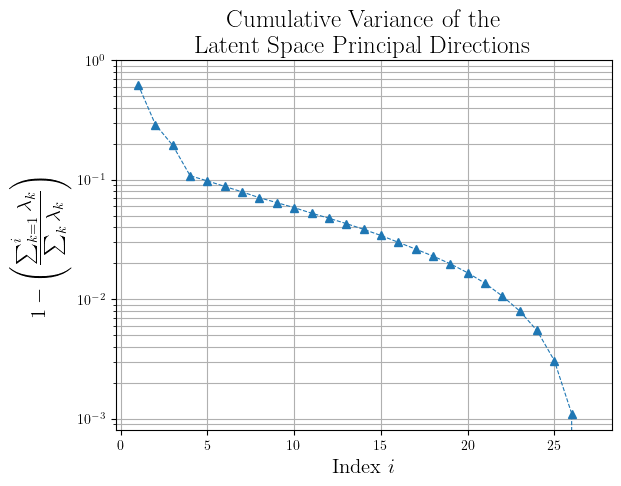

In [25]:
cum_eigs = np.cumsum(eigenvals_ls[::-1])/np.sum(eigenvals_ls)

plt.semilogy(
    np.arange(1, cum_eigs.shape[0]+1),
    1-cum_eigs, marker='^', linestyle='--', linewidth=0.8)
plt.grid(which='both')
plt.ylim(None,1.0)

plt.xlabel('Index $i$', **xlabel_kwargs)
plt.ylabel(r'$$1 - \left( \frac{\sum_{k=1}^i \lambda_k}{\sum_{k} \lambda_k} \right)$$', **ylabel_kwargs)
plt.title('Cumulative Variance of the \nLatent Space Principal Directions', **title_kwargs)

plt.savefig(dir_name_ae+'/plots/ls_cumvar.pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [26]:
# POD in actual-data space
training_data = np.reshape(training_data, (training_data.shape[0], -1))
mean_og = np.mean(training_data, axis=0)
meancentered_og = training_data - mean_og
covmat_og = np.matmul(meancentered_og.transpose(), meancentered_og) / (meancentered_og.shape[0] - 1)

eigenvals_og, eigenvecs_og = linalg.eig(covmat_og)
eigenvals_og = np.abs(eigenvals_og)
sorted_idx = np.argsort(eigenvals_og)
eigenvals_og = eigenvals_og[sorted_idx]
eigenvecs_og = eigenvecs_og[:, sorted_idx]

del(covmat_og)

In [27]:
og_eigvecs_to_analyse = 13
ls_eigvecs_to_analyse = 13

eigenvecs_og_norm = linalg.norm(eigenvecs_og[:, -og_eigvecs_to_analyse:].transpose(), axis=1)

correlation_mat = np.empty(shape=(ls_eigvecs_to_analyse, og_eigvecs_to_analyse))

ls_trainingdata = latent_states_all_trainingdata - mean_ls
ls_trainingdata_norm = linalg.norm(ls_trainingdata, axis=1)

eigvecs_ls_norm = linalg.norm(eigenvecs_ls.transpose(), axis=1)

dummy_ones_mat = np.ones_like(latent_states_all_trainingdata, dtype=FTYPE)

In [28]:
print('eigenvecs_og_norm : ', eigenvecs_og_norm)
print('eigvecs_ls_norm : ', eigvecs_ls_norm)

eigenvecs_og_norm :  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
eigvecs_ls_norm :  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1.]


In [29]:
# ls_eigenval_sum = 1.0
ls_eigenval_sum = np.sum(eigenvals_ls)
for i in range(ls_eigvecs_to_analyse):
    time_taken = time.time()
    # temp_ls = (eigenvals_ls[-i-1]/ls_eigenval_sum) * eigenvecs_ls[:, -i-1]
    # temp_ls = eigenvecs_ls[:, -i-1]
    temp_ls = (eigenvals_ls[-i-1]/ls_eigenval_sum**0.5) * eigenvecs_ls[:, -i-1]
    temp_ls += mean_ls
    temp_ls = np.reshape(temp_ls, (1,)+tuple(ls_shape))
    
    decoded_ls = np.array(ae_net.decoder_net.predict(temp_ls))
    
    decoded_ls *= normalization_constant_arr_aedata[1]
    decoded_ls += normalization_constant_arr_aedata[0]
    
    decoded_ls = np.reshape(decoded_ls, (decoded_ls.shape[0], -1))
    decoded_ls -= mean_og
    decoded_ls_norm = np.linalg.norm(decoded_ls, axis=1)

    for j in range(og_eigvecs_to_analyse):
        time_taken_j = time.time()
        coeffs = np.sum(decoded_ls * eigenvecs_og[:, -j-1], axis=1)
        coeffs /= decoded_ls_norm * eigenvecs_og_norm[-j-1]
        correlation_mat[i, j] = np.mean(coeffs)
        time_taken_j = time.time() - time_taken_j
#         print('    time_taken_j : {:02d}h {:02d}m {:02d}s'.format(
#             int(time_taken_j // 3600),
#             int((time_taken_j//60)%60),
#             int(time_taken_j % 60)
#         ))
        
    del(decoded_ls)
    del(temp_ls)
    
    time_taken = time.time() - time_taken
#     print('time_taken : {:02d}h {:02d}m {:02d}s\n'.format(
#         int(time_taken // 3600),
#         int((time_taken//60)%60),
#         int(time_taken % 60)
#     ))

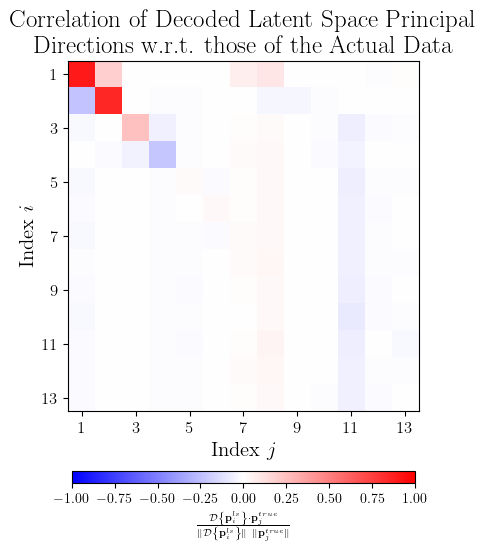

In [30]:
fig, ax = plt.subplots()
im = ax.imshow(
    correlation_mat,
    aspect='equal',
    vmin=-1.0,
    vmax=1.0,
    cmap='bwr',
    # cmap='BrBG',
)

ax.set_xticks(
    np.arange(0, og_eigvecs_to_analyse, 2),
    labels=np.arange(1, og_eigvecs_to_analyse+1, 2),
    **legend_kwargs,
)
ax.set_yticks(
    np.arange(0, ls_eigvecs_to_analyse, 2),
    labels=np.arange(1, ls_eigvecs_to_analyse+1, 2),
    **legend_kwargs,
)

ax.set_title(
    'Correlation of Decoded Latent Space Principal\nDirections w.r.t. those of the Actual Data',
    **title_kwargs,
)

ax.set_xlabel('Index $j$', **xlabel_kwargs)
ax.set_ylabel('Index $i$', **ylabel_kwargs)

fig.subplots_adjust(
    bottom=0.15,
    # left=0.1,
    # top=1.0-0.19,
)

# original data and recon data colorbar
cb_xbegin = ax.transData.transform([1.5, 0])
cb_xbegin = fig.transFigure.inverted().transform(cb_xbegin)[0]
cb_xend = ax.transData.transform([correlation_mat.shape[-1]-2.5, 0])
cb_xend = fig.transFigure.inverted().transform(cb_xend)[0]

cb_ax = fig.add_axes([cb_xbegin, 0.0, cb_xend-cb_xbegin, 0.025])
cbar = fig.colorbar(im, cax=cb_ax, orientation='horizontal')
# cbar = plt.colorbar(im)

cbar.set_label(
    r'$\frac{\mathcal{D} \left\{ \mathbf{p}^{ls}_i \right\} \cdot \mathbf{p}^{true}_j}{\|\mathcal{D} \left\{ \mathbf{p}^{ls}_i \right\}\| \ \| \mathbf{p}^{true}_j \|}$')

plt.savefig(dir_name_ae+'/plots/ls_vs_actual_principaldirections.pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [31]:
decoded_ls_pd_list = []

ls_eigenval_sum = 1.0
ls_eigenval_sum = np.sum(eigenvals_ls)
for i in range(ls_eigvecs_to_analyse):
    time_taken = time.time()
    # temp_ls = (eigenvals_ls[-i-1]/ls_eigenval_sum) * eigenvecs_ls[:, -i-1]
    temp_ls = (eigenvals_ls[-i-1]/ls_eigenval_sum**0.5) * eigenvecs_ls[:, -i-1]
    temp_ls += mean_ls
    temp_ls = np.reshape(temp_ls, (1,)+tuple(ls_shape))
    
    decoded_ls = np.array(ae_net.decoder_net.predict(temp_ls))
    
    decoded_ls *= normalization_constant_arr_aedata[1]
    decoded_ls += normalization_constant_arr_aedata[0]
    
    decoded_ls = np.reshape(decoded_ls, (decoded_ls.shape[0], -1))
    decoded_ls -= mean_og
    decoded_ls_norm = np.linalg.norm(decoded_ls, axis=1)

    decoded_ls_pd_list.append(decoded_ls)
    # del(decoded_ls)
    del(temp_ls)
    
    time_taken = time.time() - time_taken
    # print('time_taken : {:02d}h {:02d}m {:02d}s\n'.format(
    #     int(time_taken // 3600),
    #     int((time_taken//60)%60),
    #     int(time_taken % 60)
    # ))

In [32]:
actual_pd_list = []
for i in range(ls_eigvecs_to_analyse):
    # actual_pd_list.append(eigenvals_og[-i-1]*eigenvecs_og[:, -i-1])
    actual_pd_list.append(eigenvecs_og[:, -i-1])

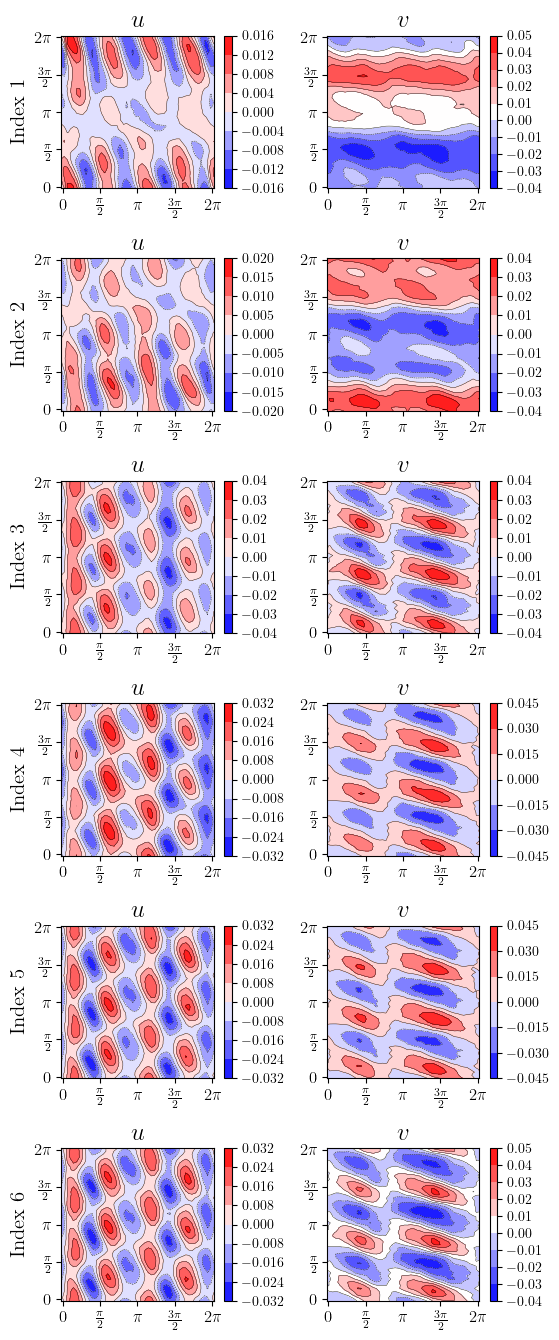

In [98]:
ls_eigvecs_to_analyse = 6
fig, ax = plt.subplots(
    ls_eigvecs_to_analyse, 2,
    figsize=np.array([3.8*2, 3.0*ls_eigvecs_to_analyse])*0.75
)
# fig, ax = plt.subplots()

xtick_pos = np.linspace(1, og_shape[-1]-1, 5, dtype=np.int32)
xtick_labels = [r'0', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$', r'$2\pi$']
for i in range(ls_eigvecs_to_analyse):
    vec = decoded_ls_pd_list[i]
    vec_norm = linalg.norm(vec)
    vec = np.reshape(vec, og_shape) / vec_norm
    # print(vec.shape, og_shape, vec_norm)
    
    u_im = ax[i, 0].contourf(vec[0].transpose(), origin='lower', cmap='bwr')
    temp = ax[i, 0].contour(vec[0].transpose(), origin='lower', colors='k', linewidths=0.3)
    v_im = ax[i, 1].contourf(vec[1].transpose(), origin='lower', cmap='bwr')
    temp = ax[i, 1].contour(vec[1].transpose(), origin='lower', colors='k', linewidths=0.3)
    
    for j in range(2):
        ax[i, j].set_xticks(xtick_pos, xtick_labels, **legend_kwargs)
#         ax[i, j].set_xlabel(r'$x$', **xlabel_kwargs)
        ax[i, j].set_yticks(xtick_pos, xtick_labels, **legend_kwargs)
        ax[i, j].set_aspect('equal')
    ax[i, 0].set_ylabel(r'Index $'+str(i+1)+'$', **ylabel_kwargs)
    ax[i, 1].set_ylabel(r' ', **ylabel_kwargs)
        
    ax[i, 0].set_title(r"$u$", **title_kwargs)
    ax[i, 1].set_title(r"$v$", **title_kwargs)
    
    error_cb_ax = plt.colorbar(u_im, ax=ax[i, 0])#, orientation='horizontal')
    error_cb_ax.ax.tick_params(axis='x', rotation=270+45)
    error_cb_ax = plt.colorbar(v_im, ax=ax[i, 1])#, orientation='horizontal')
    error_cb_ax.ax.tick_params(axis='x', rotation=270+45)

plt.tight_layout()

plt.savefig(dir_name_ae+'/plots/decoded_ae_ls_pd.pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

<AxesSubplot:label='<colorbar>'>

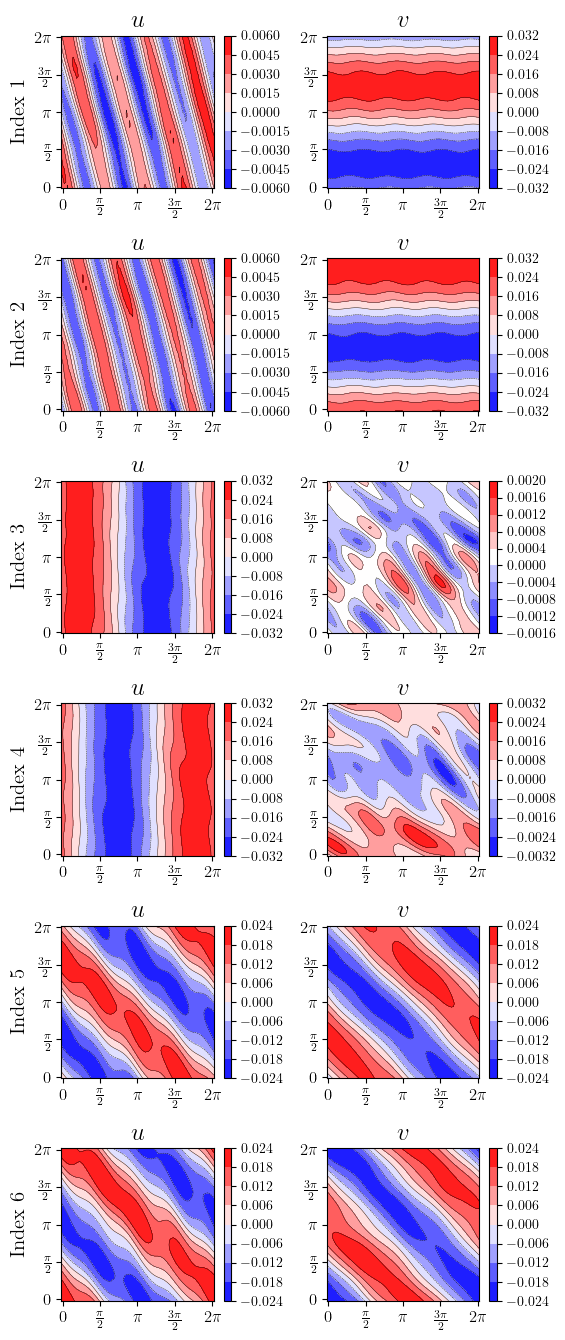

In [97]:
ls_eigvecs_to_analyse = 6
fig, ax = plt.subplots(
    ls_eigvecs_to_analyse, 2,
    figsize=np.array([3.8*2, 3.0*ls_eigvecs_to_analyse])*0.75
)
# fig, ax = plt.subplots()

xtick_pos = np.linspace(1, og_shape[-1]-1, 5, dtype=np.int32)
xtick_labels = [r'0', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$', r'$2\pi$']
for i in range(ls_eigvecs_to_analyse):
    vec = actual_pd_list[i]
    vec_norm = linalg.norm(vec)
    vec = np.reshape(vec, og_shape) / vec_norm
    # print(vec.shape, og_shape, vec_norm)
    
    u_im = ax[i, 0].contourf(vec[0].transpose(), origin='lower', cmap='bwr')
    temp = ax[i, 0].contour(vec[0].transpose(), origin='lower', colors='k', linewidths=0.3)
    v_im = ax[i, 1].contourf(vec[1].transpose(), origin='lower', cmap='bwr')
    temp = ax[i, 1].contour(vec[1].transpose(), origin='lower', colors='k', linewidths=0.3)
    
    for j in range(2):
        ax[i, j].set_xticks(xtick_pos, xtick_labels, **legend_kwargs)
#         ax[i, j].set_xlabel(r'$x$', **xlabel_kwargs)
        ax[i, j].set_yticks(xtick_pos, xtick_labels, **legend_kwargs)
        ax[i, j].set_aspect('equal')
    ax[i, 0].set_ylabel(r'Index $'+str(i+1)+'$', **ylabel_kwargs)
    ax[i, 1].set_ylabel(r' ', **ylabel_kwargs)
        
    ax[i, 0].set_title(r"$u$", **title_kwargs)
    ax[i, 1].set_title(r"$v$", **title_kwargs)
    
    error_cb_ax = plt.colorbar(u_im, ax=ax[i, 0])#, orientation='horizontal')
    error_cb_ax.ax.tick_params(axis='x', rotation=270+45)
    error_cb_ax = plt.colorbar(v_im, ax=ax[i, 1])#, orientation='horizontal')
    error_cb_ax.ax.tick_params(axis='x', rotation=270+45)

plt.tight_layout()

plt.savefig(dir_name_ae+'/plots/pod_pd.pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()